In [ ]:
!pip install -r requirements.txt

## Import libraries, load ASR function, unzip dataset, and download model

In [1]:
import os
import transformers
import torchaudio
import numpy as np
import sentencepiece
import csv
import regex as re
import pandas as pd
import string

import matplotlib.pyplot as plt
from pyctcdecode import build_ctcdecoder
from transformers import Wav2Vec2ProcessorWithLM, Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, AutoTokenizer, AutoModelForSeq2SeqLM
from scipy.io.wavfile import write

This function performs text generation from audio files in wav format.
It loads the audio file into an array, adjust the sample rate to the one required by the model (16000) and run it into the model that generates text from the waveform.

In [93]:
def asr_model(wav_file, model, processor):
    waveform, sample_rate = torchaudio.load(wav_file)
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000, resampling_method='sinc_interpolation')
    # Downsampling is required to match the model's frequency, i.e.
    # the frequency of the dataset the model was trained on.
    speech_array = resampler(waveform).squeeze().numpy()
    inputs = processor(speech_array, sampling_rate=16000, return_tensors="pt")['input_values']
    # Detach the tensors first (otherwise, they require gradients
    # to be computed); also, since we're simulating the inference
    # squeeze the resulting array at the first dimension (batch_size),
    # otherwise, leave it as is, and call batch_decode() instead.
    outputs = model(inputs)['logits'].detach().numpy().squeeze(0)
    return(processor.decode(outputs).text)

In [ ]:
# Unzip file
!unzip UKRAINER.zip

Archive:  UKRAINER.zip
   creating: UKRAINER/
   creating: UKRAINER/16147090271336/
   creating: UKRAINER/16147090271336/etc/
 extracting: UKRAINER/16147090271336/etc/txt.done.data  
   creating: UKRAINER/16147090271336/wav/
 extracting: UKRAINER/16147090271336/wav/spk_id_10001_16147120260842.wav  
 extracting: UKRAINER/16147090271336/wav/spk_id_10003_16147116872582.wav  
 extracting: UKRAINER/16147090271336/wav/spk_id_10003_16147116877122.wav  
 extracting: UKRAINER/16147090271336/wav/spk_id_10004_16147116611902.wav  
 extracting: UKRAINER/16147090271336/wav/spk_id_10004_16147116616062.wav  
 extracting: UKRAINER/16147090271336/wav/spk_id_10004_16147116619872.wav  
 extracting: UKRAINER/16147090271336/wav/spk_id_10007_16147120493892.wav  
 extracting: UKRAINER/16147090271336/wav/spk_id_10018_16147119706432.wav  
 extracting: UKRAINER/16147090271336/wav/spk_id_10018_16147119713532.wav  
 extracting: UKRAINER/16147090271336/wav/spk_id_10022_16147119242792.wav  
 extracting: UKRAINER/161

Download model and processor to be used in the function above.

In [94]:
model = Wav2Vec2ForCTC.from_pretrained("Yehor/wav2vec2-xls-r-300m-uk-with-small-lm")

In [95]:
processor = Wav2Vec2ProcessorWithLM.from_pretrained("Yehor/wav2vec2-xls-r-300m-uk-with-small-lm")

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'snapshot_download': allow_regex. Will not be supported from version '0.12'.

Please use `allow_patterns` and `ignore_patterns` instead.
  warnings.warn(message, FutureWarning)


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading the LM will be faster if you build a binary file.
Reading /home/studio-lab-user/.cache/pyctcdecode/models--Yehor--wav2vec2-xls-r-300m-uk-with-small-lm/snapshots/bbd936400e7566ba44560440aa4abd05b5983c17/language_model/5gram_correct.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


## Prepare dataset

After extracting the files, change directory to the files location. List all the directories in the location to access the files from them.

In [6]:
# Save list of directories in the dataset folder

%cd '/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER'

folders = os.listdir()
print(len(folders))

/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER
39


Create a variable to store the file paths and their corresponding transcripts. The variable is a list containing sublists for each pair if path and transcript.
Then, open the file in each directory of the list created before. For each line of the opened file, remove the '/' in the beginning of the line, to keep the path in the appropriate format. Because this dataset was larger than the other ones, and the format of the transcript file was different in one of the subdirectories, the subdirectories were run one at a time manually. In the last subdirectory (titles), the file extension are separated by a space instead of a dot, so that is replaced in the loop, as well as the newline character at the end of the string. Finally, a string containing two spaces is used to split the line into a list containing those two elements.

In [29]:
# Open text files in the dataset folders and save each row in a list (splitting the file path and the transcription into an inner list)
text = []

file = open(folders[38]+'/etc/txt.done.data', 'r', encoding='utf8')
for line in file:
    line = line.lstrip('/').replace(' wav', '.wav ')
    text.append(line.rstrip(' \n').split('  '))

As some audio files crashed the notebook sometimes because they were too large, it was necessary to check the index of the last sentence with text generation, in order to continue from where it had stopped (skipping the large file).

In [9]:
text.index(['UKRAINER/titles/wav/spk_id_78946613_161383281588621.wav', 'уже немає того життя яке я можу сюди привнести'])

22680

In [11]:
print(len(text))

38312


## Generate Text

Change the working directory again to create a csv file that will store all the paths, transcripts, and generated text from the ASR model. The file creation is done in a separate cell because it writes a header to the file, this way the header is not written again when re-running the cell to append more sentences.

In [44]:
%cd '/home/studio-lab-user/sagemaker-studiolab-notebooks/'

/home/studio-lab-user/sagemaker-studiolab-notebooks


In [25]:
with open('ukrainer_transcription_generated-text.csv', 'w', encoding='UTF8', newline='\n') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(['path', 'transcription', 'generated_text'])

The loop below calls the function to generate text. The output is saved into a variable that is appended to the list containing the path and transcript for the sentence.
Lastly, the sublist corresponding to the sentence, containing path + transcript + generated text, is written as a new line into the file created earlier.

PS.: the option to write one line at a time to the file was made because with large datasets, the notebook can crash for a number or reasons. When this happens, this cell can be re-run from where it stopped by replacing the 0 that sets the initial range in the for loop with the number of the last line written to the file (and not the last line, since the range starts at 0 and the lines in the file are counted from 1). Otherwise, the content appended to the text variable would have been lost.

The try/except block was added here to catch the 'RuntimeError: Calculated padded input size per channel: (0). Kernel size: (10). Kernel size can't be greater than actual input size'. This error was raised for small files that were 0 seconds long. The block also caught some lines that were empty in the transcript file and were filtered out later.

In [12]:
# Append generated text in the list
for i in range(len(text)):
    try:
        gen_text = asr_model(text[i][0], model, processor)
        text[i].append(gen_text)

        with open('ukrainer_transcription_generated-text.csv', 'a', encoding='UTF8', newline='\n') as f:
            writer = csv.writer(f)

            # write the data
            writer.writerows(text[i:i+1])
    except:
        print(text[i][0]) # Print paths that raised error and could not have text generated 
print('Success!') # Prints a message to indicate that the end of the directory was reached, as opposed to a crash while loading one of the files

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/models/wav2vec2/feature_extraction_wav2vec2.py:98: RuntimeWarning: Mean of empty slice.
  normed_input_values = [(x - x.mean()) / np.sqrt(x.var() + 1e-7) for x in input_values]
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/models/wav2vec2/feature_extraction_wav2vec2.py:98: RuntimeWarning: Degrees of freedom <= 0 for slice
  normed_input_values = [(x - x.mean()) / np.sqrt(x.var() + 1e-7) for x in input_values]
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/studio-lab-user/.conda/envs/default/lib/python3.9/si

UKRAINER/titles/wav/spk_id_64007389_161383305728181.wav












UKRAINER/titles/wav/spk_id_35326895_161383399779647.wav
UKRAINER/titles/wav/spk_id_68315198_161383431193311.wav
UKRAINER/titles/wav/spk_id_31975979_161383460902802.wav
UKRAINER/titles/wav/spk_id_52113553_161383513355639.wav






























































































UKRAINER/titles/wav/spk_id_90577061_161384985645278.wav








UKRAINER/titles/wav/spk_id_24452947_161385661522235.wav
UKRAINER/titles/wav/spk_id_94003157_161385720692021.wav
UKRAINER/titles/wav/spk_id_66265991_161385748491302.wav
UKRAINER/titles/wav/spk_id_71861223_161385809030891.wav
UKRAINER/titles/wav/spk_id_40026723_161385873890895.wav
UKRAINER/titles/wav/spk_id_68977226_161385974924164.wav
UKRAINER/titles/wav/spk_id_55540796_161385997947961.wav
UKRAINER/titles/wav/spk_id_89046580_161386064165348.wav
UKRAINER/titles/wav/spk_id_57918442_161386094868881.wav
Success!


## Length Classification

Load the csv containing the wav path, transcript, and generated text as a pandas dataframe.

In [2]:
transcripts = pd.read_csv("ukrainer_transcription_generated-text (1).csv", encoding='utf-8')
transcripts

,path,transcription,generated_text
0,UKRAINER/16147090271336/wav/spk_id_8413_161471...,получилось,по учились
1,UKRAINER/16147090271336/wav/spk_id_8413_161471...,амбасадор,або саду
2,UKRAINER/16147090271336/wav/spk_id_10309_16147...,вимикайте,вимикаєте
3,UKRAINER/16147090271336/wav/spk_id_8990_161471...,мобільний телефон,мобільний телефони
4,UKRAINER/16147090271336/wav/spk_id_8430_161471...,час при цьому,час та краса та и привід це на
...,...,...,...
48630,UKRAINER/titles/wav/spk_id_26460061_1613861088...,я роблю масло,я роблю масло
48631,UKRAINER/titles/wav/spk_id_10011582_1613861089...,ми тепер з волонтерами та друзями все робимо д...,ми тепер много друзі волонтери ми робимо що со...
48632,UKRAINER/titles/wav/spk_id_73156467_1613861090...,є у мене декілька друзів у києві я їм даю добр...,по мені пару друзів київ со я я їм дав добре п...
48633,UKRAINER/titles/wav/spk_id_18556677_1613861092...,ми робимо бартер,ми робимо партнери


To calculate the length difference between the transcript and the generated text, try to subtract the length of the generated text from the transcript length. Append the result to a list and save the list as a column in the dataframe. An exception will occur at some lines, as some wav files had no speech on them (usually just music), and therefore there was no generated text to calculate the length. If an exception is catched, append the value -999 to easily filter out these values in the categorization, and append the path to the no_text list, so the wav file can be deleted later.
In the next cell, the paths stored in the no_text list are saved into a text file.

In [3]:
# Calculate length difference between transcripts
length = []
no_text = []
for i in range(len(transcripts['path'])):
    try:
        length.append(len(transcripts['transcription'][i]) - len(transcripts['generated_text'][i]))
    # Files with no generated text (they are usually just music) are saved into a list and their length is set as -999 so easily spot them at the dataframe
    except:
        no_text.append(transcripts['path'][i])
        length.append(-999)

In [118]:
# Save paths with no generated text in a txt file
with open('no_text_ukrainer.txt', 'w', encoding='utf-8') as f:
    for i in no_text:
        f.write(i+'\n')

In [4]:
# Create column in dataset
transcripts['length_diff'] = length
transcripts.head()

,path,transcription,generated_text,length_diff
0,UKRAINER/16147090271336/wav/spk_id_8413_161471...,получилось,по учились,0
1,UKRAINER/16147090271336/wav/spk_id_8413_161471...,амбасадор,або саду,1
2,UKRAINER/16147090271336/wav/spk_id_10309_16147...,вимикайте,вимикаєте,0
3,UKRAINER/16147090271336/wav/spk_id_8990_161471...,мобільний телефон,мобільний телефони,-1
4,UKRAINER/16147090271336/wav/spk_id_8430_161471...,час при цьому,час та краса та и привід це на,-17


Based on the difference, classificate each transcript into one of three categories: incomplete (difference is equal or less than -10), inconclusive (difference is equal to or less than -5), or complete (difference is greater than -5). For this dataset, an additional category for 'no text' cases is created. Save the classification as a new column of the dataframe and then save the dataframe as a csv file.

In [5]:
# Classificate transcripts according to length difference

transcripts['length_cat'] = [0 for x in range(len(transcripts['path']))]

for i in range(len(transcripts['length_diff'])):
    if transcripts['length_diff'][i] <= -998:
        transcripts['length_cat'][i] = 'no text'
    elif transcripts['length_diff'][i] <= -10:
        transcripts['length_cat'][i] = 'incomplete'
    elif transcripts['length_diff'][i] <= -5:
        transcripts['length_cat'][i] = 'inconclusive'
    else:
        transcripts['length_cat'][i] = 'complete'
    

transcripts.to_csv('transcripts_length_cat_ukrainer.csv', encoding='utf-8')
transcripts.head()

/tmp/ipykernel_74/916222144.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts['length_cat'][i] = 'complete'


,path,transcription,generated_text,length_diff,length_cat
0,UKRAINER/16147090271336/wav/spk_id_8413_161471...,получилось,по учились,0,complete
1,UKRAINER/16147090271336/wav/spk_id_8413_161471...,амбасадор,або саду,1,complete
2,UKRAINER/16147090271336/wav/spk_id_10309_16147...,вимикайте,вимикаєте,0,complete
3,UKRAINER/16147090271336/wav/spk_id_8990_161471...,мобільний телефон,мобільний телефони,-1,complete
4,UKRAINER/16147090271336/wav/spk_id_8430_161471...,час при цьому,час та краса та и привід це на,-17,incomplete


To have a picture about the completeness of the transcripts, count and plot the values in each category.

In [8]:
# Count n of transcripts per category
transcripts['length_cat'].value_counts()

complete        35882
incomplete       7608
inconclusive     5046
no text            99
Name: length_cat, dtype: int64

<AxesSubplot: >

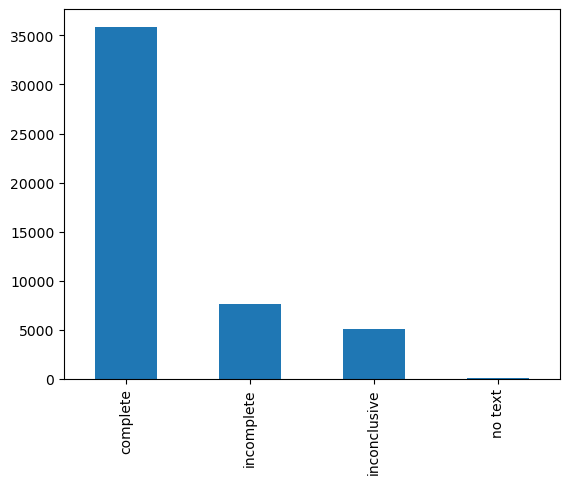

In [115]:
transcripts['length_cat'].value_counts().plot.bar()

Select only the transcripts classificated as incomplete or inconclusive and save them into a text file for manual inspection. The text file contains the path, the transcript, and the generated text, each in a different line, with a blank line separating each sentence.

In [6]:
# Select only transcripts in the incomplete and inconclusive categories
txt = transcripts.loc[(transcripts['length_cat'] == 'incomplete') | (transcripts['length_cat'] == 'inconclusive')]
txt

,path,transcription,generated_text,length_diff,length_cat
4,UKRAINER/16147090271336/wav/spk_id_8430_161471...,час при цьому,час та краса та и привід це на,-17,incomplete
13,UKRAINER/16147090271336/wav/spk_id_9318_161471...,і до цій програмі,і до вашого міста в цій програмі,-15,incomplete
14,UKRAINER/16147090271336/wav/spk_id_9533_161471...,ми розповімо можна,ми розповімо як нас можна,-7,inconclusive
19,UKRAINER/16147090271336/wav/spk_id_8910_161471...,я тут дуже,я йшов якраз тут і тут ти і тут я тих стрича г...,-76,incomplete
20,UKRAINER/16147090271336/wav/spk_id_8910_161471...,книжечки цікаво,книжечки про дивиться і кава,-13,incomplete
...,...,...,...,...,...
48604,UKRAINER/titles/wav/spk_id_28859238_1613861061...,я намагався порахувати у мене були до сто різн...,найде я пробував врахувати я подумаю мене уже ...,-14,incomplete
48617,UKRAINER/titles/wav/spk_id_67134128_1613861073...,там або хімія або багато антибіотиків,там батьки мій весь дуже много антибіотик вай ...,-13,incomplete
48621,UKRAINER/titles/wav/spk_id_66634111_1613861077...,покласти новий електровівчар кормити з ясел чи...,покласти новий електропастух вай на яслікормит...,-15,incomplete
48623,UKRAINER/titles/wav/spk_id_57079060_1613861079...,ви доїте дві буйволиці але працюєте максимум т...,со ви маєте видоєти два буйвліця но треба макс...,-16,incomplete


In [117]:
# Save in a text file
with open('transcripts_ukrainer.txt', 'w', encoding='utf-8') as f:
    for t in range(len(txt)):
        f.write(txt.iloc[t,0]+'\n')
        f.write(txt.iloc[t,1]+'\n')
        f.write(txt.iloc[t,2]+'\n')
        f.write('\n\n')

## Identify and delete invalid data

Read the csv file for the generated text, create a list to store paths and another list to store transcripts for filtering. Print the first five items in each list and the variable length to make sure the data was extracted correctly.

In [4]:
# Create lists with all the wav file paths and with the transcripts in the csv
path = []
transcript = []
with open('ukrainer_transcription_generated-text.csv', 'r', encoding='UTF8', newline='\n') as f:
    for line in f:
        p = re.findall(r'(.+wav),.+\n', line)
        t = re.findall('.+wav,(.+)\n', line)
        if p != []:
            path.append(p[0])
            transcript.append(t[0])

print(len(path))
print(path[:5])
print(len(transcript))
print(transcript[:5])

48639
['UKRAINER/16147090271336/wav/spk_id_8413_16147115305922.wav', 'UKRAINER/16147090271336/wav/spk_id_8413_16147115307542.wav', 'UKRAINER/16147090271336/wav/spk_id_10309_16147115309082.wav', 'UKRAINER/16147090271336/wav/spk_id_8990_16147115310602.wav', 'UKRAINER/16147090271336/wav/spk_id_8430_16147115312152.wav']
48639
['получилось,по учились', 'амбасадор,або саду', 'вимикайте,вимикаєте', 'мобільний телефон,мобільний телефони', 'час при цьому,час та краса та и привід це на']


Because wav files are spread in different subdirectories, the loop below visits each one of the subdirectories, lists the wav files in them, and store the information in the wav_paths list. Another list stores the absolute wav paths, so that the invalid files can be deleted later. It also stores the total number of files, to make sure all files names were appended correctly and to allow later comparison between the number of files at the start and the number of files remaining after each filter.

In [8]:
# Create a list with all the wav file names to compare with the ones in the csv and look for the ones that have no generated text
n_files = 0
wav_paths = []
absolute_wav_paths = []

for i in range(39):
    directory = '/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/'+folders[i]+'/wav'
    %cd {directory}
    wp = os.listdir()
    wav_paths = wav_paths + wp
    n_files += len(os.listdir())
    for wav in wp:
        absolute_wav_paths.append(directory+'/'+wav)
print(n_files)
print(absolute_wav_paths[:5])

/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147090271336/wav
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147097301666/wav
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147103371072/wav
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147106928042/wav
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147107313492/wav
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147107885242/wav
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147110265382/wav
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147118166882/wav
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147120703502/wav
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147124541662/wav
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147125712412/wav
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147126677282/wav
/home/studio-lab-user/sagemaker-studiola

### Too large or empty files

The 'broken' list contains paths to files that crashed the kernel for being too large (index 0 - 27), or were 'empty', meaning they had 1kb size and were 0 seconds long
For the large files, these paths were saved manually as the kernel crashed and there was no way to print and store their paths during runtime. The paths of the empty files were added to the list from the prints during the text generation. For each of those cases, a file with the paths is saved on Google Drive (too big files and empty files).
For the data pipeline, file size will be verified in the cleaning phase, before the function call to run the ASR model. The paths are stored in this variable to be filtered out later.
In the next cell, for each file in the broken list, look for the file name in the absolute_wav_paths list. When the name is found, use the absolute path to delete the file.

In [10]:
broken = ['spk_id_10381_16147120188862.wav',
'spk_id_9846_16147120652842.wav',
'spk_id_9614_16147120660522.wav',
'spk_id_9456_16147123803852.wav',
'spk_id_9147_16147125500872.wav',
'spk_id_9792_16147130965462.wav',
'spk_id_682989_16147124616672.wav',
'spk_id_10321_16147136815242.wav',
'spk_id_10568_16147135657352.wav',
'spk_id_9945_16147135819462.wav', 
'spk_id_10110_16147135932512.wav',
'spk_id_7991_16147137433212.wav',
'spk_id_8094_16147139582372.wav',
'spk_id_8609_16147140272822.wav',
'spk_id_10566_16147141946562.wav',
'spk_id_8872_16147143794652.wav',
'spk_id_9895_16147147975972.wav',
'spk_id_9522_16147148143082.wav',
'spk_id_9983_16147146741212.wav',
'spk_id_8939_16147146787142.wav',
'spk_id_8643_16147146802462.wav',
'spk_id_9449_16147150333512.wav',
'spk_id_9682_16147151683582.wav',
'spk_id_11325_16147151692292.wav',
'spk_id_10369_16147152870342.wav',
'spk_id_105979_16147152942492.wav',
'spk_id_11340_16147155664122.wav',
'spk_id_569276_16147156122362.wav',
'spk_id_13532106_161380792952426.wav',
'spk_id_23735805_161382861501620.wav',
'spk_id_24452947_161385661522235.wav',
'spk_id_28571378_161382748175826.wav',
'spk_id_31975979_161383460902802.wav',
'spk_id_35326895_161383399779647.wav',
'spk_id_37252792_161382383092511.wav',
'spk_id_40026723_161385873890895.wav',
'spk_id_52113553_161383513355639.wav',
'spk_id_55540796_161385997947961.wav',
'spk_id_57918442_161386094868881.wav',
'spk_id_64007389_161383305728181.wav',
'spk_id_66265991_161385748491302.wav',
'spk_id_67699540_161381912340451.wav',
'spk_id_68315198_161383431193311.wav',
'spk_id_68977226_161385974924164.wav',
'spk_id_71861223_161385809030891.wav',
'spk_id_72686404_161383949293872.wav',
'spk_id_72726013_161381830901005.wav',
'spk_id_75757441_161382190755597.wav',
'spk_id_77332999_161380728022177.wav',
'spk_id_79518796_161382411712535.wav',
'spk_id_80451021_161380733297124.wav',
'spk_id_84924818_161382716488793.wav',
'spk_id_85595884_161382958485071.wav',
'spk_id_86880900_161382709450913.wav',
'spk_id_89046580_161386064165348.wav',
'spk_id_90577061_161384985645278.wav',
'spk_id_93475059_161383161382333.wav',
'spk_id_94003157_161385720692021.wav',
'spk_id_94864002_161380897285582.wav'
]

In [20]:
broken_absolute_paths = []

for br in broken:
    for awp in absolute_wav_paths:
        if br in awp:
            broken_absolute_paths.append(awp)
            os.remove(awp)

### Missing transcripts

Next, the missing transcripts were identified. First, a list was created to store all the wav paths that were accessed during the text generation. The code loops through the paths saved in the ukrainer_transcription_generated_text.csv, and extracts only the file name, without the full path. Then, it adds the broken (too big and empty) files to the list (as the transcripts existed, despite not being used).
The next cell selects the files that exist in audio format but do not have transcripts associated with them, by subtracting the accessed files from the total wav_paths list.
Finally, the missing transcripts are saved to a txt file.

In [ ]:
# List Accessed wav file names (without full path)
ac_p = []

for ac in path:
    ac = re.findall('UKRAINER/.+/wav/(.+wav)', ac)
    ac_p += ac

# Add wav file names to known broken files
ac_paths = ac_p + broken

49068


In [32]:
# Select files missing in the csv and the 'broken' list
missing_transcript = set(wav_paths) - set(ac_paths)
missing_transcript = list(missing_transcript)
print(len(missing_transcript))
print(missing_transcript[:5])

374
['spk_id_34594577_161384719841469.wav', 'spk_id_79009835_161382994143326.wav', 'spk_id_98321654_161382993841927.wav', 'spk_id_80505892_161383134793454.wav', 'spk_id_62414030_161384663536193.wav']


In [38]:
# These files were missed because they don't have transcripts associated with them. Save them into a txt file for future reference
with open('missing_transcripts_ukrainer.txt', 'w', encoding='utf-8') as f:
    for mt in missing_transcript:
        f.write(mt+'\n')

In [34]:
# Delete audio files with missing transcripts

%cd '/home/studio-lab-user/sagemaker-studiolab-notebooks/'

for af in audio_files:
    for audio in af:
        for mt in missing_transcripts:
            if mt in audio:
                print(audio)
                os.remove(audio)

/home/studio-lab-user/sagemaker-studiolab-notebooks
UKRAINER/16147107313492/wav/spk_id_10755_16147125495762.wav
UKRAINER/16147120703502/wav/spk_id_9392_16147130958212.wav
UKRAINER/16147145012312/wav/spk_id_9973_16147150367272.wav
UKRAINER/16147150732942/wav/spk_id_10350_16147154606442.wav
UKRAINER/16147154359212/wav/spk_id_475571_16147158375902.wav
UKRAINER/titles/wav/spk_id_10233722_161382199323648.wav
UKRAINER/titles/wav/spk_id_10275849_161382704237643.wav
UKRAINER/titles/wav/spk_id_10802816_161383681602671.wav
UKRAINER/titles/wav/spk_id_11106059_161382982319774.wav
UKRAINER/titles/wav/spk_id_11451110_161381618044752.wav
UKRAINER/titles/wav/spk_id_11664088_161382986918227.wav
UKRAINER/titles/wav/spk_id_11754485_161382343571493.wav
UKRAINER/titles/wav/spk_id_11798374_161382339296929.wav
UKRAINER/titles/wav/spk_id_11885412_161384667000874.wav
UKRAINER/titles/wav/spk_id_12625367_161382346992355.wav
UKRAINER/titles/wav/spk_id_12959135_161383690048598.wav
UKRAINER/titles/wav/spk_id_129624

### Audio with no text

Open the text file in which the paths for files with no text are stored. In the next cell, loop through file paths and delete audio files.

In [28]:
# Open file with paths to audio files with no text and save paths into a list
%cd '/home/studio-lab-user/sagemaker-studiolab-notebooks'

no_text = []

with open('no_text_ukrainer.txt', 'r', encoding='utf-8') as f:
    for line in f:
        no_text.append(line.rstrip('\n'))

print(no_text[:5])

/home/studio-lab-user/sagemaker-studiolab-notebooks
['UKRAINER/titles/wav/spk_id_86504564_161380735857795.wav', 'UKRAINER/titles/wav/spk_id_74430807_161380739046271.wav', 'UKRAINER/titles/wav/spk_id_13924806_161380743676029.wav', 'UKRAINER/titles/wav/spk_id_42246873_161380772081223.wav', 'UKRAINER/titles/wav/spk_id_99425319_161380822202359.wav']


In [ ]:
# Delete audio files with no text

%cd '/home/studio-lab-user/sagemaker-studiolab-notebooks/'

for nt in no_text:
    os.remove(nt)

### Clean transcript file from titles subdirectory from empty lines and delete lines corresponding to files with no text

Read txt.done.data file from the titles subdirectory and check if each read line is empty or not. If the line is empty, add 1 to the count variable (to check if the number matches the identified before). Otherwise, append the line to the filtered_lines list. Print the length of filtered_lines, count, and the last appended line to see if it worked as expected.
Next, loop through filtered_list to also delete the lines corresponding to audio files with no text (as they had transcripts, despite the absence of text in the audio files).
Save the content of filtered_lines in a new txt.done.data file, overwriting the old file in the titles subdirectory.

In [56]:
# Filter out empty lines from transcripts in the titles directory

%cd 'home/studio-lab-user/sagemaker-studiolab-notebooks'

filtered_lines = []
count = 0

file = open('UKRAINER/titles/etc/txt.done.data', 'r', encoding='utf8')
for line in file:
    line = line.lstrip('/').replace(' wav', '.wav ')
    line = line.rstrip(' \n').split('  ')
    if line[0] == '' or line[0] == ' ':
        count += 1
    else:
        filtered_lines.append(line)

print(len(filtered_lines))
print(count)
print(line)

37989
323
['UKRAINER/titles/wav/spk_id_88862203_161386109333716.wav', 'а я йому натомість сир']


In [60]:
# Filter out paths from audio files with no text from transcript file

for nt in no_text:
    for i in range(len(filtered_lines)):
        if nt in filtered_lines[i]:
            del filtered_lines[i]

print(len(filtered_lines))

37890


In [67]:
%cd '/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/titles/etc'

with open('txt.done.data', 'w', encoding='utf8') as f:
    for i in range(len(filtered_lines)):
        f.write(filtered_lines[i][0]+'\t'+filtered_lines[i][1]+'\n')

/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/titles/etc


### Delete too large or no text lines from transcripts

For deleting the transcripts corresponding to large files and files with no text, it was necessary to first get all the directories in which there were files in those conditions. The first for loop bellow goes through the absolute path of the files, selects the path until the folder above 'wav' and then replaces 'wav' for 'etc', which is the directory where the transcripts are saved. The modified path is appended to the list 'directories' if it doesn't already exist in that list, since some of the files belong to a same directory.
The next loop visits each directory, reads all the lines from the transcript file and store them in the 'text_file' list. The list is then saved as a value in the dictionary 'text_files', the key being the directory path.

In [45]:
directories = []
text_files = {}


for bap in broken_absolute_paths:
    directory = ''.join(re.findall('^(.+)/wav', bap))+'/etc'
    if directory not in directories:
        directories.append(directory)

for directory in directories:
    text_file = []
    %cd {directory}
    with open('txt.done.data', 'r', encoding='utf8') as f:
        for line in f:
            text_file.append(line)
    text_files[directory] = text_file

/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147090271336/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147103371072/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147110265382/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147118166882/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147107313492/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147126677282/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147131021312/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147136018852/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147137225742/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147137451772/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147139606292/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147140343242/etc
/home/studio-lab-user/sagemaker-studiola

Next, we loop through the directories folder again, through the broken paths, and through the dictionaries. In each directory, we check if the file path exists in the corresponding dictionary keys. If it does, delete it from the dictionary. The check is included in a try/except block because as the keys are deleted, the last indexes of the list become out of range.

In [47]:
filtered_text_files = {}
filtered_text_file = []

#for i in text_files.get('/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147090271336/etc')[:5]

for d in directories:
    for bap in broken_absolute_paths:
        for i in range(len(text_files.get(d))):
            try:
                if bap.lstrip('/home/studio-lab-user/sagemaker-studiolab-notebooks/') in text_files.get(d)[i]:
                    del text_files.get(d)[i]
            except:
                continue

Finally, visit each directory, open a text file overwriting the old one, and write the contents of the corresponding dictionary to it.

In [49]:
for directory in directories:
    %cd {directory}
    with open('txt.done.data', 'w', encoding='utf8') as f:
        for i in range(len(text_files.get(directory))):
            f.write(text_files.get(directory)[i])

/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147090271336/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147103371072/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147110265382/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147118166882/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147107313492/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147126677282/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147131021312/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147136018852/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147137225742/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147137451772/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147139606292/etc
/home/studio-lab-user/sagemaker-studiolab-notebooks/UKRAINER/16147140343242/etc
/home/studio-lab-user/sagemaker-studiola

## Filter medical sentences from incomplete transcripts

### Open and extract words from vocabulary files

Open text files containing the vocabularies for anatomy, diseases, and specialties. Read the files and store each line as an item in a list named after the vocabulary type.

In [27]:
anatomy = []
with open('vocabulary_anatomy.txt', encoding='utf8') as f:
    for line in f:
        anatomy.append(line.rstrip('\n'))
print(anatomy[:5])

diseases = []
with open('vocabulary_diseases.txt', encoding='utf8') as f:
    for line in f:
        diseases.append(line.rstrip('\n'))
print(diseases[:5])

specialties = []
with open('vocabulary_specialties.txt', encoding='utf8') as f:
    for line in f:
        specialties.append(line.rstrip('\n'))
print(specialties[:5])

['anatomy анатомія', 'anatomic / anatomical анатомічний, анатомічна, анатомічне, анатомічні', 'human body людський організм', 'skeleton скелет, кістяк', 'bone кістка']
["health здоров'я", 'healthy здоровий, здорова, здорове, здорові', 'condition стан', 'physical фізичний', 'physical condition фізичний стан']
['doctor лікар, лікарка', 'doctors лікарі, лікарки', 'medic медик, медикиня', 'medics медики, медикині', '']


Extract only the Ukrainian words from the vocabularies. Separate the line contents according to their language using regular expression. The English words appear first, and are separated by a slash when synonyms for the same word exist. The Ukrainian words appear next, with synonyms for the same entry separated by a comma. For that reason, we check if there is a slash in the line, applying the appropriate expression according to the result.  Because information in parenthesis, in English, are sometimes included after the Ukrainian word(s), the 'extra' variable also looks for that occurrence and strips it from the Ukrainian text. After that, we check if the Ukrainian variable is not empty (as some lines are not yet complete and contain only text in English), and append the text to the vocabulary list.

In [28]:
vocab_anatomy = []
for a in anatomy:
    en = re.findall('[a-z\s]+', a)
    en = [i.strip(' ') for i in en if len(i) > 2]
    extra = re.findall('.+(\(.+)', a)
    extra = ''.join(extra)
    if '/' in a:
        uk = re.findall('^.+/ [a-z\s]+(.+)', a)
    else:
        uk = re.findall('^[a-z\s]+(.+)', a)
    if uk != [] and uk != [' ']:
        vocab_anatomy.append(uk[0].strip(extra))

print(vocab_anatomy[:15])

['анатомія', 'анатомічний, анатомічна, анатомічне, анатомічні', 'людський організм', 'скелет, кістяк', 'кістка', 'кістки', "м'яз", "м'язи", 'суглоб', 'хрящ', 'сухожилля', "зв'язка", 'судина', 'кров', 'кровоносні судини']


In [29]:
vocab_diseases = []
for d in diseases:
    en = re.findall('[a-z\s]+', d)
    en = [i.strip(' ') for i in en if len(i) > 2]
    if '/' in d:
        uk = re.findall("^.+/ [\S\s]+ (\S+ \S+|\S)$", d)
    else:
        uk = re.findall('^[-|\d|a-z\s]+(.+)', d)
    uk = ''.join(uk)
    if len(uk) > 2:
        vocab_diseases.append(uk)
print(vocab_diseases[:5])
print(type(vocab_diseases[0]))

["здоров'я", 'здоровий, здорова, здорове, здорові', 'стан', 'фізичний', 'фізичний стан']
<class 'str'>


In [30]:
vocab_specialties = []
for s in specialties:
    en = re.findall('[a-z\s]+', s)
    en = [i.strip(' ') for i in en if len(i) > 2]
    if '/' in s:
        uk = re.findall("^.+/ [\S\s]+ (\S+ \S+|\S)$", s)
    else:
        uk = re.findall('^[-|\d|a-z\s]+(.+)', s)
    uk = ''.join(uk)
    if len(uk) > 2:
        vocab_specialties.append(uk)
print(vocab_specialties[:5])

['лікар, лікарка', 'лікарі, лікарки', 'медик, медикиня', 'медики, медикині', 'сімейна медицина']


Because individual words are necessary for the filtering process, we split the strings containing more than one word or expression into a list, and also remove trailing spaces from the resulting strings inside the list.

In [31]:
for i in range(len(vocab_anatomy)):
    vocab_anatomy[i] = vocab_anatomy[i].split(',')
    for j in range(len(vocab_anatomy[i])):
        vocab_anatomy[i][j] = vocab_anatomy[i][j].strip(' ')
print(vocab_anatomy[1][1])

анатомічна


In [34]:
for i in range(len(vocab_specialties)):
    vocab_specialties[i] = vocab_specialties[i].split(',')
    for j in range(len(vocab_specialties[i])):
        vocab_specialties[i][j] = vocab_specialties[i][j].strip(' ')
print(vocab_specialties[:5])

[['лікар', 'лікарка'], ['лікарі', 'лікарки'], ['медик', 'медикиня'], ['медики', 'медикині'], ['сімейна медицина']]


In [32]:
for i in range(len(vocab_diseases)):
    vocab_diseases[i] = vocab_diseases[i].split(',')
    for j in range(len(vocab_diseases[i])):
        vocab_diseases[i][j] = vocab_diseases[i][j].strip(' ')
print(vocab_diseases[:5])

[["здоров'я"], ['здоровий', 'здорова', 'здорове', 'здорові'], ['стан'], ['фізичний'], ['фізичний стан']]


The entries that could not be fixed by the previous steps are manually corrected as follows:

In [33]:
vocab_diseases[62] = ['дефіцит вітаміну B12']
vocab_diseases[307] = ['вірус папіломи людини (ВПЛ)']
vocab_diseases[308] = ['вірус імунодефіциту людини']
vocab_diseases[309] = ['синдром набутого імунодефіциту (СНІД)']
vocab_diseases[325] = ['суїцидальна ідеація']

In [18]:
vocab_specialties[34] = ['спеціаліст', 'спеціалістка']

### Filter transcripts

With the words prepared, loop through the the rows from the generated_text column in the incomplete transcripts dataframe.
For each row, we verify if the exact word appears in the text, using regular expressions. Despite making the process very slow, this is necessary because unless there is an exact match, many irrelevant entries will be selected from words that contain the relevant word as a substring, but that are not relevant for our purposes (for instance, a sentence with the word 'bear' could be selected because it contains the anatomy word 'ear').
Each time a word is encountered, we concatenate it to the string 'words'. If 'words' is not empty at the end of the outter loop, we append the file path, the reference transcript, the generated text, and the medical words encountered to the 'filtered' variable.

In [47]:
filtered = []

for i in range(len(txt)):
    words = ''
    for av in range(len(vocab_anatomy)):
        for a in range(len(vocab_anatomy[av])):
            if re.search('\\b'+vocab_anatomy[av][a]+'\\b', txt.iloc[i,2]) != None:
                words += vocab_anatomy[av][a]+' '
    for dv in range(len(vocab_diseases)):
        for d in range(len(vocab_diseases[dv])):
            if re.search('\\b'+vocab_diseases[dv][d]+'\\b', txt.iloc[i,2]) != None:
                words += vocab_diseases[dv][d]+' '
    for sv in range(len(vocab_specialties)):
        for s in range(len(vocab_specialties[sv])):
            if re.search('\\b'+vocab_specialties[sv][s]+'\\b', txt.iloc[i,2]) != None:
                words += vocab_specialties[sv][s]+' '
    if words != '':
        filtered.append([txt.iloc[i,0], txt.iloc[i,1], txt.iloc[i,2], words])

Check the length of the filtered list (number of sentences filtered), and inspect the first five items in the list.

In [48]:
print(len(filtered))
for i in range(5):
    print(filtered[i])

238
['UKRAINER/16147090271336/wav/spk_id_10309_16147116082432.wav', 'до люди вважають', 'то одні пробіг чому ви те зустрілися ну побачить теж святиняка щоках бо в залі серце києва вважають ну люди вважають', 'серце ']
['UKRAINER/16147090271336/wav/spk_id_9100_16147119593262.wav', 'його час перевірок', 'його так не подає просто як ресторану це брата так живу склад мами цікаво буде добре але то веколбжалику сарни алергія час перевіримо', 'алергія ']
['UKRAINER/16147090271336/wav/spk_id_8799_16147120006622.wav', 'мене дуже', 'мене я не знаю навіть зуби і я кажу вибач а де конструктів насправді зміни дуже', 'зуби ']
['UKRAINER/16147090271336/wav/spk_id_8201_16147120130332.wav', 'мені допомагають', 'мені вухо не допомагають', 'вухо ']
['UKRAINER/16147090271336/wav/spk_id_9496_16147120638062.wav', 'тобто клас дзвіночок', 'тобто коста зуби а тут я дзвіночок', 'зуби ']


Finally, save the path, the reference transcript, the generated text, and the medical words, separated by a blank line, in a text file.

In [49]:
# Save filtered incomplete transcripts (using anatomy, diseases, and specialties vocabularies)
with open('medical_incomplete_transcripts_ukrainer.txt', 'w', encoding='utf-8') as f:
    for t in range(len(filtered)):
        f.write(filtered[t][0]+'\n')
        f.write(filtered[t][1]+'\n')
        f.write(filtered[t][2]+'\n')
        f.write('Medical word(s): '+filtered[t][3]+'\n')
        f.write('\n\n')

## Filter audio files with medical incomplete transcripts

Open the text file with incomplete medical transcripts, extract the lines with the wav paths, and append them to a list. Check if the paths extracted and the list length match the incomplete medical transcripts.

In [15]:
medical_filtered = []

with open('medical_incomplete_transcripts_ukrainer.txt', 'r', encoding='utf-8') as f:
    for line in f:
        mf = re.findall('(UKRAINER/.+)\n', line)
        if mf != []:
            medical_filtered.append(mf[0])

print(medical_filtered[:5])

['UKRAINER/16147090271336/wav/spk_id_10309_16147116082432.wav', 'UKRAINER/16147090271336/wav/spk_id_9100_16147119593262.wav', 'UKRAINER/16147090271336/wav/spk_id_8799_16147120006622.wav', 'UKRAINER/16147090271336/wav/spk_id_8201_16147120130332.wav', 'UKRAINER/16147090271336/wav/spk_id_9496_16147120638062.wav']
238


Import the shutil module to copy the wav files with incomplete medical transcripts to a newly created folder. Using the same module, compress the folder into a zip file to be downloaded.

In [16]:
import shutil

for mf in medical_filtered:
    shutil.copy(mf, 'files_with_incomplete_transcripts')

In [24]:
shutil.make_archive('files_with_incomplete_transcripts', 'zip', '/home/studio-lab-user/sagemaker-studiolab-notebooks/files_with_incomplete_transcripts')

'/home/studio-lab-user/sagemaker-studiolab-notebooks/files_with_incomplete_transcripts.zip'